In [2]:
#%pip install torcheval scikit-learn matplotlib pandas 

In [3]:
"""from model import GPTConfig, GPT

# seq_len = 1024, 
# small = dict(vocab_size = 50257, d_model = 768, num_heads = 1, num_layers = 1)
gptconf = GPTConfig()
gptconf.n_head = 1
gptconf.n_layer = 1
gptconf.n_embd = 100
gpt = GPT(gptconf)"""

'from model import GPTConfig, GPT\n\n# seq_len = 1024, \n# small = dict(vocab_size = 50257, d_model = 768, num_heads = 1, num_layers = 1)\ngptconf = GPTConfig()\ngptconf.n_head = 1\ngptconf.n_layer = 1\ngptconf.n_embd = 100\ngpt = GPT(gptconf)'

In [4]:
#gptconf

In [5]:
#gpt

In [6]:
!curl -O https://download.pytorch.org/tutorial/data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  8227k      0 --:--:-- --:--:-- --:--:-- 8253k


## Prepare the data

In [7]:
!head tatoeba/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


In [8]:
import pandas as pd

df = pd.read_csv('tatoeba/eng-fra.txt', sep='\t', names=('en', 'fr'))

In [9]:
df.head()

,en,fr
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [10]:
df['sample'] = df.apply(lambda row: f"FRA: {row['fr']} ENG: {row['en']}", axis=1)

In [11]:
df['sample']

0                                        FRA: Va ! ENG: Go.
1                                    FRA: Cours ! ENG: Run!
2                                   FRA: Courez ! ENG: Run!
3                                 FRA: Ça alors ! ENG: Wow!
4                                  FRA: Au feu ! ENG: Fire!
                                ...                        
135837    FRA: Une empreinte carbone est la somme de pol...
135838    FRA: La mort est une chose qu'on nous décourag...
135839    FRA: Puisqu'il y a de multiples sites web sur ...
135840    FRA: Si quelqu'un qui ne connaît pas vos antéc...
135841    FRA: Il est peut-être impossible d'obtenir un ...
Name: sample, Length: 135842, dtype: object

In [12]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
#vec.fit_transform(df['Va !'] + df['Go.'])

CPU times: user 2.08 s, sys: 758 ms, total: 2.84 s
Wall time: 1.91 s


In [13]:
vec.fit(df['sample'])

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [14]:
analyzer = vec.build_analyzer()
df['tokens'] = df['sample'].map(analyzer)

In [15]:
df['tokens'].map(len).max()

np.int64(101)

In [16]:
df['X'] = df['tokens'].map(lambda x: list(map(vec.vocabulary_.get, x)))

In [17]:
df['X-'] = df['X'].map(lambda l: l[:-1])

In [18]:
df['y'] = df['X'].map(lambda l: l[1:])
df.head()

,en,fr,sample,tokens,X,X-,y
0,Go.,Va !,FRA: Va ! ENG: Go.,"[fra, va, eng, go]","[13294, 31616, 11109, 14014]","[13294, 31616, 11109]","[31616, 11109, 14014]"
1,Run!,Cours !,FRA: Cours ! ENG: Run!,"[fra, cours, eng, run]","[13294, 7445, 11109, 26204]","[13294, 7445, 11109]","[7445, 11109, 26204]"
2,Run!,Courez !,FRA: Courez ! ENG: Run!,"[fra, courez, eng, run]","[13294, 7428, 11109, 26204]","[13294, 7428, 11109]","[7428, 11109, 26204]"
3,Wow!,Ça alors !,FRA: Ça alors ! ENG: Wow!,"[fra, ça, alors, eng, wow]","[13294, 32924, 1372, 11109, 32784]","[13294, 32924, 1372, 11109]","[32924, 1372, 11109, 32784]"
4,Fire!,Au feu !,FRA: Au feu ! ENG: Fire!,"[fra, au, feu, eng, fire]","[13294, 2699, 12581, 11109, 12766]","[13294, 2699, 12581, 11109]","[2699, 12581, 11109, 12766]"


In [25]:
a = (df['X-'][0], df['y'][0][:2])
b = (df['X-'][0], df['y'][0][:3])
a,b
b[1][0] = 2
a,b

(([13294, 31616, 11109], [31616, 11109]),
 ([13294, 31616, 11109], [2, 11109, 14014]))

## Fit a single batch

In [20]:
batch = df.sample(1)
batch

,en,fr,sample,tokens,X,X-,y
132444,I remember playing the original Pac-Man game w...,Je me rappelle en train de jouer au jeu Pac-Ma...,FRA: Je me rappelle en train de jouer au jeu P...,"[fra, je, me, rappelle, en, train, de, jouer, ...","[13294, 16841, 18653, 24340, 10945, 30658, 812...","[13294, 16841, 18653, 24340, 10945, 30658, 812...","[16841, 18653, 24340, 10945, 30658, 8123, 1694..."


In [21]:
import numpy as np

np.array(batch['X'].values[0])

array([13294, 16841, 18653, 24340, 10945, 30658,  8123, 16943,  2699,
       16875, 20969, 18279, 20759, 23978, 33471, 11064, 11109, 25026,
       22247, 30111, 20752, 20969, 18279, 13711, 32583, 32476, 17130])

In [22]:
import torch

gpt(torch.LongTensor(np.array(batch['X'].values[0]).reshape(-1, 1)))[0].shape

NameError: name 'gpt' is not defined

In [ ]:
from torch import nn

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss = loss_fn(gpt(torch.LongTensor(np.array(batch['X-'].values[0]).reshape(-1, 1)))[0].squeeze(),
               torch.LongTensor(np.array(batch['y'].values[0])))

In [ ]:
gpt(torch.LongTensor(np.array(batch['X-'].values[0]).reshape(-1, 1)))[0].squeeze().shape

torch.Size([8, 50304])

In [ ]:
torch.LongTensor(np.array(batch['y'].values[0]))

tensor([16841, 31913, 31277, 21853,  7203, 11109, 32444,  4042])

In [ ]:
loss.backward()

In [ ]:
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.01)

In [ ]:
optimizer.step()

In [ ]:
gpt(torch.LongTensor(np.array(batch['X-'].values[0]).reshape(-1, 1)))[0].shape#.argsort()

torch.Size([8, 1, 50304])

In [ ]:
gpt(torch.LongTensor(np.array(batch['X-'].values[0]).reshape(-1, 1)))[0].argsort()

tensor([[[ 1538, 11477, 31310,  ..., 11109,  7203, 16841]],

        [[29151,  1538, 50148,  ..., 31913, 31277, 16841]],

        [[40695, 34752,  5207,  ..., 21853, 31913, 31277]],

        ...,

        [[11477, 29151, 11257,  ..., 11109,  4042, 32444]],

        [[11477, 29151, 11257,  ..., 11109,  4042, 32444]],

        [[11477, 11257, 47175,  ..., 11109,  4042, 32444]]])

In [ ]:
batch['y']

19976    [16841, 31913, 31277, 21853, 7203, 11109, 3244...
Name: y, dtype: object

In [ ]:
from torcheval.metrics import ReciprocalRank

In [ ]:
from torcheval.metrics.functional import reciprocal_rank

In [ ]:
reciprocal_rank(
    gpt(torch.LongTensor(np.array(batch['X-'].values[0]).reshape(-1, 1)))[0].squeeze(),
    torch.LongTensor(np.array(batch['y'].values[0]))
)

tensor([1.0000, 0.3333, 1.0000, 1.0000, 1.0000, 0.3333, 1.0000, 0.5000])

## Fit random tensors

In [ ]:
import torch

X = torch.LongTensor([[11428, 12315, 5632, 3267], [11428, 12315, 5632, 0]])
gpt(X)[0].shape

NameError: name 'gpt' is not defined

In [ ]:
gpt(X)[0].argsort()

tensor([[[25440, 46288,  5991,  ..., 25565, 33393,  3267]],

        [[37534,  9278,    99,  ...,  5046, 49394, 29115]]])

In [ ]:
gpt(X)

(tensor([[[ 0.3981,  0.3975,  0.0206,  ...,  0.3684, -0.4606,  0.0600]],
 
         [[ 1.3447,  0.3985,  0.2490,  ...,  0.2444, -0.2929, -0.0146]]],
        grad_fn=<UnsafeViewBackward0>),
 None)

In [ ]:
from torch import nn

loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss = loss_fn(gpt(X)[0].squeeze(), torch.LongTensor([42, 43]))

In [ ]:
loss.backward()

In [ ]:
optimizer = torch.optim.SGD(gpt.parameters(), lr=0.01)

In [ ]:
optimizer.step()

In [ ]:
gpt(X)[0].argsort()

tensor([[[13582, 16400,  4550,  ...,  3267,    43,    42]],

        [[13582, 32857, 35811,  ...,  5453,     0,    43]]])

## Feed random tensors to bidirectional GRU

In [ ]:
encoder = nn.Sequential(
    nn.Embedding(5, 20),
    nn.GRU(20, 20, bidirectional=True)
)

In [ ]:
outputs, hidden = encoder(torch.LongTensor([3, 1, 4]).reshape(-1, 1))

In [ ]:
outputs.shape

torch.Size([3, 1, 40])

In [ ]:
hidden.shape

torch.Size([2, 1, 20])

In [ ]:
outputs[2]

tensor([[-0.3972,  0.1245, -0.3717, -0.2424,  0.1423, -0.3030,  0.4151, -0.0310,
          0.4605, -0.0190, -0.0313, -0.1602,  0.1545, -0.3362, -0.6486, -0.2658,
         -0.0125, -0.1723, -0.1596, -0.5312, -0.1724, -0.0721,  0.1267,  0.3350,
          0.1189,  0.3145,  0.1714,  0.0088, -0.0799,  0.2033,  0.0217, -0.2214,
         -0.1796, -0.2963, -0.1212, -0.1062, -0.0934,  0.0994, -0.0301,  0.0050]],
       grad_fn=<SelectBackward0>)

In [ ]:
hidden.reshape(1, 1, -1) == outputs[2]

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False]]])

In [ ]:
outputs[2]

tensor([[-0.3972,  0.1245, -0.3717, -0.2424,  0.1423, -0.3030,  0.4151, -0.0310,
          0.4605, -0.0190, -0.0313, -0.1602,  0.1545, -0.3362, -0.6486, -0.2658,
         -0.0125, -0.1723, -0.1596, -0.5312, -0.1724, -0.0721,  0.1267,  0.3350,
          0.1189,  0.3145,  0.1714,  0.0088, -0.0799,  0.2033,  0.0217, -0.2214,
         -0.1796, -0.2963, -0.1212, -0.1062, -0.0934,  0.0994, -0.0301,  0.0050]],
       grad_fn=<SelectBackward0>)

In [ ]:
hidden

tensor([[[-0.3972,  0.1245, -0.3717, -0.2424,  0.1423, -0.3030,  0.4151,
          -0.0310,  0.4605, -0.0190, -0.0313, -0.1602,  0.1545, -0.3362,
          -0.6486, -0.2658, -0.0125, -0.1723, -0.1596, -0.5312]],

        [[ 0.2310, -0.1245, -0.0272, -0.2793,  0.5366,  0.2850, -0.6503,
           0.0258,  0.0596,  0.4157,  0.1752,  0.0337, -0.1269,  0.2088,
          -0.1778, -0.2047, -0.0791,  0.3262, -0.0884,  0.0373]]],
       grad_fn=<StackBackward0>)

In [ ]:
outputs[0]

tensor([[-0.3298,  0.0817, -0.2638, -0.1957, -0.0397, -0.0418,  0.4203,  0.0817,
         -0.0915,  0.1995, -0.1490, -0.0372,  0.1521,  0.0314, -0.4558,  0.0157,
         -0.2785, -0.4804, -0.0535, -0.1869,  0.2310, -0.1245, -0.0272, -0.2793,
          0.5366,  0.2850, -0.6503,  0.0258,  0.0596,  0.4157,  0.1752,  0.0337,
         -0.1269,  0.2088, -0.1778, -0.2047, -0.0791,  0.3262, -0.0884,  0.0373]],
       grad_fn=<SelectBackward0>)

In [ ]:
hidden.reshape(1, 1, -1) == outputs[0]

tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])

## One attention layer

In [ ]:
import matplotlib.pyplot as plt

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.query = nn.Linear(20, 10, bias=False)
        self.key = nn.Linear(40, 10, bias=False)
        self.value = nn.Linear(40, 30)

    def forward(self, x, y):
        q = self.query(y)
        k = self.key(x)
        v = self.value(x)
        attention_scores = q @ k.transpose(1, 2)
        # print(attention_scores.detach().numpy().shape)
        attention_weights = torch.softmax(attention_scores, dim=0)
        # print(attention_weights.detach().numpy())

        fig, ax = plt.subplots()
        ax.imshow(attention_weights.detach().numpy())
        ax.set_yticks(range(3))
        ax.set_yticklabels([f"$x_{i}$" for i in range(1, 4)])
        ax.set_xticks(range(5))
        ax.set_xticklabels([f"$y_{i}$" for i in range(1, 6)])
        print(ax.get_ylim())

        ax_top = ax.twiny()
        ax.set_xlim(-0.5, 4.5)
        ax_top.set_xlim(-0.5, 4.5)
        print(ax.get_xlim())
        print(ax_top.get_xlim())
        # ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(range(5))
        ax_top.set_xticklabels([f"$y_{i}$" for i in range(0, 5)])
        print(ax.get_xlim())
        print(ax_top.get_xlim())
        plt.show()
        
        return attention_weights @ v

In [ ]:
[f"$y_{i}$" for i in range(1, 6)]

['$y_1$', '$y_2$', '$y_3$', '$y_4$', '$y_5$']

In [ ]:
outputs, hidden = encoder(torch.LongTensor([3, 1, 4]).reshape(-1, 1))

In [ ]:
outputs.shape

torch.Size([3, 1, 40])

In [ ]:
!uv add matplotlib

Resolved 90 packages in 1ms
Audited 72 packages in 0.01ms


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


(np.float64(2.5), np.float64(-0.5))
(np.float64(-0.5), np.float64(4.5))
(np.float64(-0.5), np.float64(4.5))
(np.float64(-0.5), np.float64(4.5))
(np.float64(-0.5), np.float64(4.5))


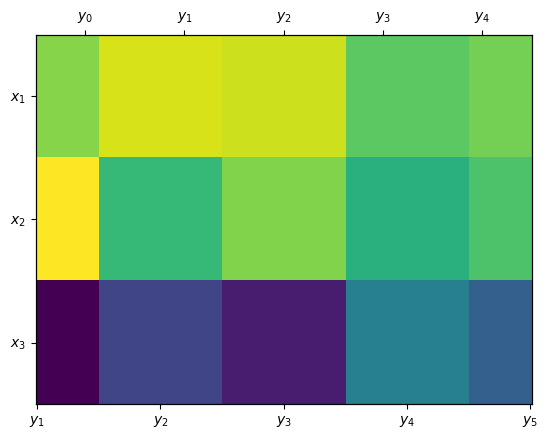

torch.Size([3, 5, 30])

In [ ]:
attention = Attention()

attention(outputs, torch.rand((5, 20))).shape

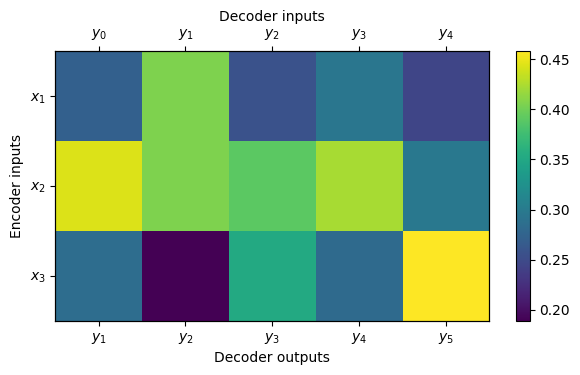

In [ ]:
import matplotlib.pyplot as plt
import torch

# Dummy 3x5 tensor
attention_weights = torch.softmax(torch.rand(3, 5), axis=0)

fig, ax = plt.subplots(figsize=(7,3.5))

# Display image
im = ax.imshow(attention_weights.detach().numpy(), aspect='auto')

# Set ticks for main axis
ax.set_yticks(range(3))
ax.set_yticklabels([f"$x_{i}$" for i in range(1, 4)])
ax.set_xticks(range(5))
ax.set_xticklabels([f"$y_{i}$" for i in range(1, 6)])

# Make sure axes match data coordinates
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(2.5, -0.5)  # imshow flips y by default
ax.set_ylabel("Encoder inputs")
ax.set_xlabel("Decoder outputs")

# Add top axis
ax_top = ax.twiny()
ax_top.set_xlabel("Decoder inputs")

# Match x-limits exactly
ax_top.set_xlim(ax.get_xlim())

# Set ticks and labels for top axis
ax_top.set_xticks(range(5))
ax_top.set_xticklabels([f"$y_{i - 1}$" for i in range(1, 6)])

fig.colorbar(im, ax=ax)
plt.savefig('attention-weights.png', format='png', bbox_inches='tight')
plt.show()


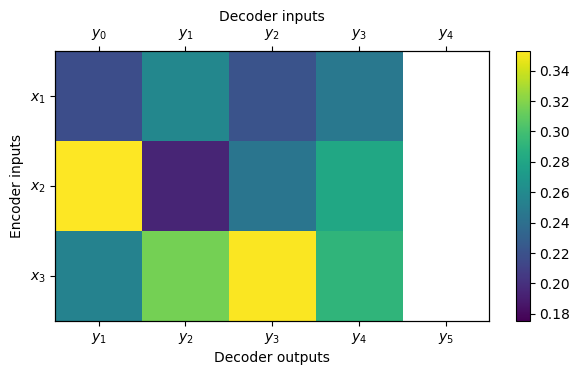

In [ ]:
import matplotlib.pyplot as plt
import torch

# Dummy 4x4 tensor
attention_weights = torch.softmax(torch.rand(4, 4), axis=0)

fig, ax = plt.subplots(figsize=(7,3.5))

# Display image
im = ax.imshow(attention_weights.detach().numpy(), aspect='auto')

# Set ticks for main axis
ax.set_yticks(range(3))
ax.set_yticklabels([f"$x_{i}$" for i in range(1, 4)])
ax.set_xticks(range(5))
ax.set_xticklabels([f"$y_{i}$" for i in range(1, 6)])

# Make sure axes match data coordinates
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(2.5, -0.5)  # imshow flips y by default
ax.set_ylabel("Encoder inputs")
ax.set_xlabel("Decoder outputs")

# Add top axis
ax_top = ax.twiny()
ax_top.set_xlabel("Decoder inputs")

# Match x-limits exactly
ax_top.set_xlim(ax.get_xlim())

# Set ticks and labels for top axis
ax_top.set_xticks(range(5))
ax_top.set_xticklabels([f"$y_{i - 1}$" for i in range(1, 6)])

fig.colorbar(im, ax=ax)
plt.savefig('attention-weights.png', format='png', bbox_inches='tight')
plt.show()


In [ ]:
mask = torch.tril(torch.ones(4, 4), diagonal=-1)
mask

tensor([[0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.]])

In [ ]:
masked_attention = attention_weights.masked_fill(mask.bool(), -torch.inf)
masked_attention

tensor([[0.2415, 0.0000, 0.0000, 0.0000],
        [  -inf, 0.3156, 0.0000, 0.0000],
        [  -inf,   -inf, 0.5421, 0.0000],
        [  -inf,   -inf,   -inf, 1.0000]])

In [ ]:
attention_weights = torch.softmax(masked_attention, axis=0)
attention_weights

tensor([[1.0000, 0.4218, 0.2688, 0.1749],
        [0.0000, 0.5782, 0.2688, 0.1749],
        [0.0000, 0.0000, 0.4623, 0.1749],
        [0.0000, 0.0000, 0.0000, 0.4754]])

In [ ]:
attention_weights.sum(axis=0)

tensor([1., 1., 1., 1.])

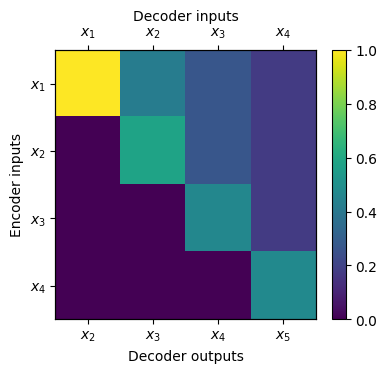

In [ ]:
fig, ax = plt.subplots(figsize=(4.2,3.5))

# Display image
im = ax.imshow(attention_weights.detach().numpy(), aspect='auto')

# Set ticks for main axis
ax.set_yticks(range(4))
ax.set_yticklabels([f"$x_{i}$" for i in range(1, 5)])
ax.set_xticks(range(4))
ax.set_xticklabels([f"$x_{i}$" for i in range(2, 6)])

# Make sure axes match data coordinates
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(3.5, -0.5)  # imshow flips y by default
ax.set_ylabel("Encoder inputs")
ax.set_xlabel("Decoder outputs")

# Add top axis
ax_top = ax.twiny()
ax_top.set_xlabel("Decoder inputs")

# Match x-limits exactly
ax_top.set_xlim(ax.get_xlim())

# Set ticks and labels for top axis
ax_top.set_xticks(range(4))
ax_top.set_xticklabels([f"$x_{i}$" for i in range(1, 5)])

fig.colorbar(im, ax=ax)
plt.savefig('attention-weights-gpt.png', format='png', bbox_inches='tight')
plt.show()


# Probably found a bug in matplotlib 😩

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


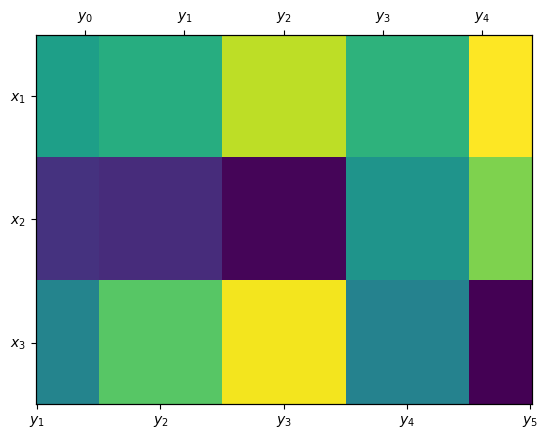

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example 3x5 matrix
attention_weights = np.random.rand(3, 5)

fig, ax = plt.subplots()
ax.imshow(attention_weights, aspect='equal')

# Set y-ticks and labels
ax.set_yticks(range(3))
ax.set_yticklabels([f"$x_{i}$" for i in range(1, 4)])

# Set x-ticks and labels for the bottom axis
ax.set_xticks(range(5))
ax.set_xticklabels([f"$y_{i}$" for i in range(1, 6)])

# Create a twin x-axis on top
ax_top = ax.twiny()

# Set the same x-limits for both axes
ax.set_xlim(-0.5, 4.5)
ax_top.set_xlim(-0.5, 4.5)

# Set x-ticks and labels for the top axis
ax_top.set_xticks(range(5))
ax_top.set_xticklabels([f"$y_{i}$" for i in range(0, 5)])

plt.show()
